Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [39]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import glob
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.regularizers import l2

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import InputLayer, Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomContrast

In [ ]:
train_root = pathlib.Path('data/train')

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [40]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("./Train")
data_dir_test = pathlib.Path("./Test")

In [41]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing and Create a dataset

Define some parameters for the loader:

In [42]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [50]:
train_ds, val_ds = image_dataset_from_directory(
    directory="./Train",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    validation_split=0.2,
    subset="both",
    seed = 123)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Using 447 files for validation.


In [52]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

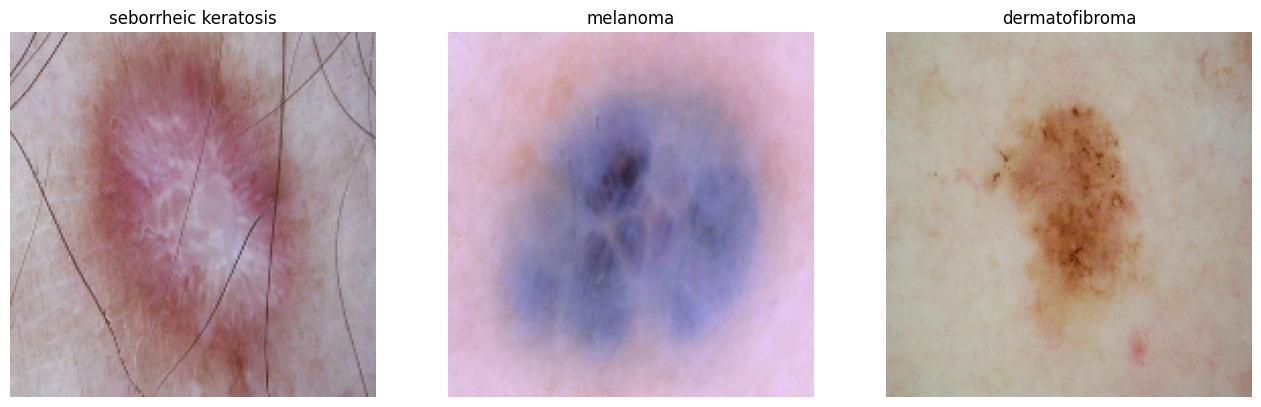

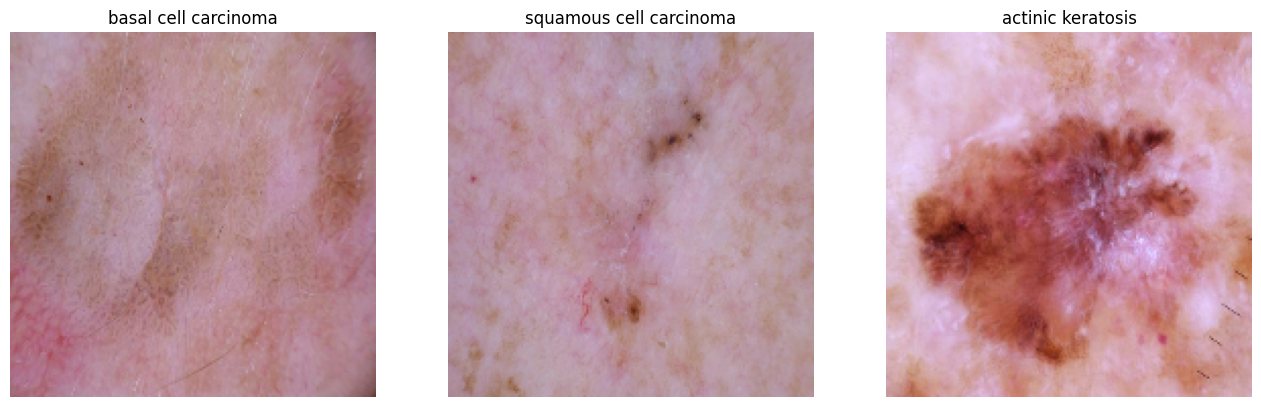

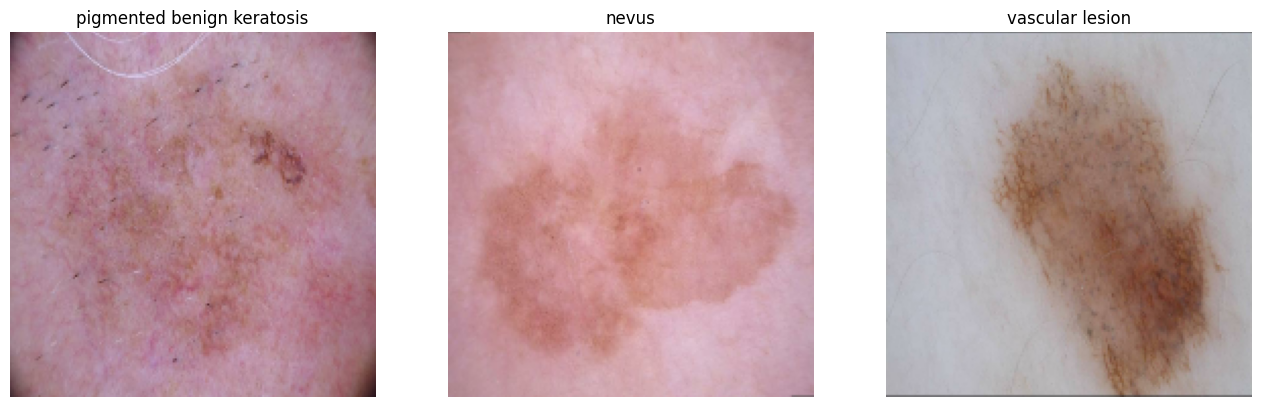

<Figure size 18000x8000 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt

def plot_images(images, labels, class_names, num_images=5):
    plt.figure(figsize=(180,80))
    label_array = []
    ran_index = 0
    for index in range(num_images):
        if not labels[index] in label_array:
            label_array.append(labels[index])
            ran_index = ran_index +1
            plt.subplot(1, num_images, ran_index)
            image = Image.fromarray(images[index].astype('uint8'), 'RGB')
            plt.imshow(image, cmap=plt.colormaps['viridis'])
            plt.title(class_names[labels[index]])
            plt.axis("off")

            if (ran_index)%3 == 0:
                plt.show()
                plt.figure(figsize=(180,80))

    plt.show()

train_x = np.asarray(list(train_ds.map(lambda x, y: x))[0])
train_y = np.asarray(list(train_ds.map(lambda x, y: y))[0])
val_x = np.asarray(list(val_ds.map(lambda x, y: x))[0])
val_y = np.asarray(list(val_ds.map(lambda x, y: y))[0])

plot_images(train_x.astype("int32"), train_y.astype("int32"), class_names, 32)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [54]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### First model

In [55]:
model = Sequential()
model.add(InputLayer(input_shape=train_x.shape[1:]))
model.add(Rescaling(scale=1/255))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

In [56]:
#  Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [57]:
# View the summary of all layers
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 activation_12 (Activation)  (None, 180, 180, 64)      0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 90, 90, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 90, 90, 64)        36928     
                                                                 
 activation_13 (Activation)  (None, 90, 90, 64)        0         
                                                      

***Train the model***

In [58]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 272s 5s/step - loss: 5.3474 - accuracy: 0.2215 - val_loss: 1.9369 - val_accuracy: 0.2819
Epoch 2/20
56/56 [==============================] - 251s 4s/step - loss: 1.8605 - accuracy: 0.3198 - val_loss: 1.8042 - val_accuracy: 0.3982
Epoch 3/20
56/56 [==============================] - 235s 4s/step - loss: 1.6235 - accuracy: 0.4308 - val_loss: 1.5459 - val_accuracy: 0.4631
Epoch 4/20
56/56 [==============================] - 217s 4s/step - loss: 1.5378 - accuracy: 0.4621 - val_loss: 1.6619 - val_accuracy: 0.4161
Epoch 5/20
56/56 [==============================] - 220s 4s/step - loss: 1.3934 - accuracy: 0.5050 - val_loss: 1.5016 - val_accuracy: 0.4944
Epoch 6/20
56/56 [==============================] - 231s 4s/step - loss: 1.2468 - accuracy: 0.5592 - val_loss: 1.5253 - val_accuracy: 0.5168
Epoch 7/20
56/56 [==============================] - 216s 4s/step - loss: 1.1463 - accuracy: 0.5938 - val_loss: 1.5542 - val_accuracy: 0.4922
Epoch 8/20
56

### Visualizing training results

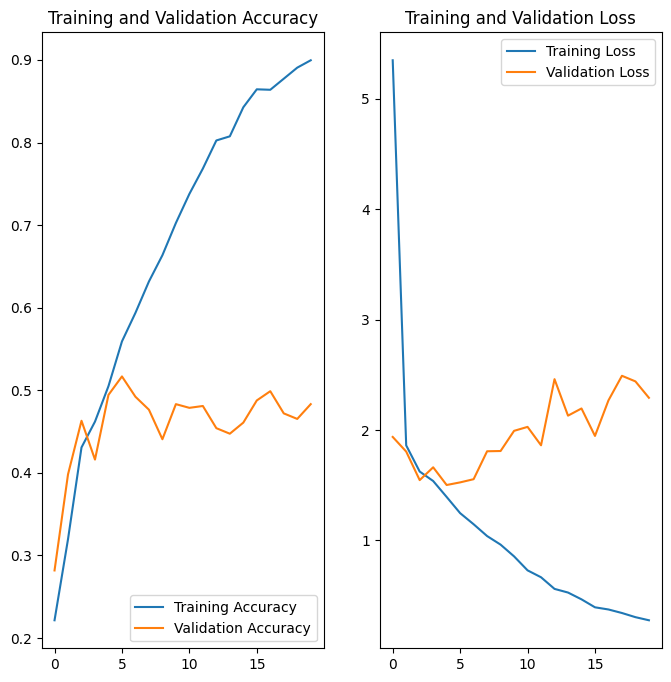

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

***First Model findings:*** First model train accuracy is around 90% but validation accuracy is 48.32%. The model is overfit.

### Second Model
Adding Augmentation

In [51]:
for images, labels in train_ds.take(1):
    original_image = images[0]
    break

In [30]:
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical")
])

***Analysing Augmentation***

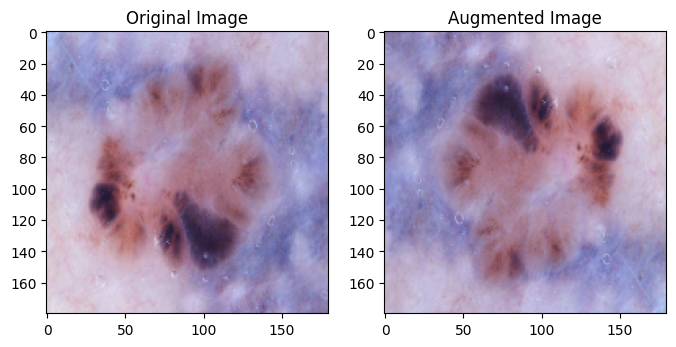

In [53]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image.numpy().astype("uint8"))

# Apply augmentation to the image
augmented_image = data_augmentation(tf.expand_dims(original_image, 0))  # Add batch dimension

# Display the augmented image
plt.subplot(1, 2, 2)
plt.title("Augmented Image")
plt.imshow(tf.squeeze(augmented_image).numpy().astype("uint8"))
plt.show()

### Creating Second model with augmentation

In [54]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model_2 = Sequential()
model_2.add(data_augmentation)
model_2.add(InputLayer(input_shape=train_x.shape[1:]))
model_2.add(Rescaling(scale=1/255))

model_2.add(Conv2D(64, (3, 3), padding='same'))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Conv2D(64, (3, 3), padding='same'))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.25))

model_2.add(Flatten())
model_2.add(Dense(256))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.25))
model_2.add(Dense(num_classes, activation='softmax'))



***Compiling the model***

In [55]:
model_2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

***Training the model***

In [56]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20

history_2 = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 279s 5s/step - loss: 5.0775 - accuracy: 0.2578 - val_loss: 1.8002 - val_accuracy: 0.3602
Epoch 2/20
56/56 [==============================] - 231s 4s/step - loss: 1.7797 - accuracy: 0.3521 - val_loss: 1.6590 - val_accuracy: 0.4183
Epoch 3/20
56/56 [==============================] - 207s 4s/step - loss: 1.6400 - accuracy: 0.4074 - val_loss: 1.5896 - val_accuracy: 0.4631
Epoch 4/20
56/56 [==============================] - 222s 4s/step - loss: 1.5786 - accuracy: 0.4381 - val_loss: 1.6674 - val_accuracy: 0.4318
Epoch 5/20
56/56 [==============================] - 255s 5s/step - loss: 1.5251 - accuracy: 0.4565 - val_loss: 1.5678 - val_accuracy: 0.4810
Epoch 6/20
56/56 [==============================] - 252s 5s/step - loss: 1.4806 - accuracy: 0.4805 - val_loss: 1.6959 - val_accuracy: 0.4318
Epoch 7/20
56/56 [==============================] - 254s 5s/step - loss: 1.4328 - accuracy: 0.4799 - val_loss: 1.4820 - val_accuracy: 0.5078
Epoch 8/20
56

***Visualizing the results***

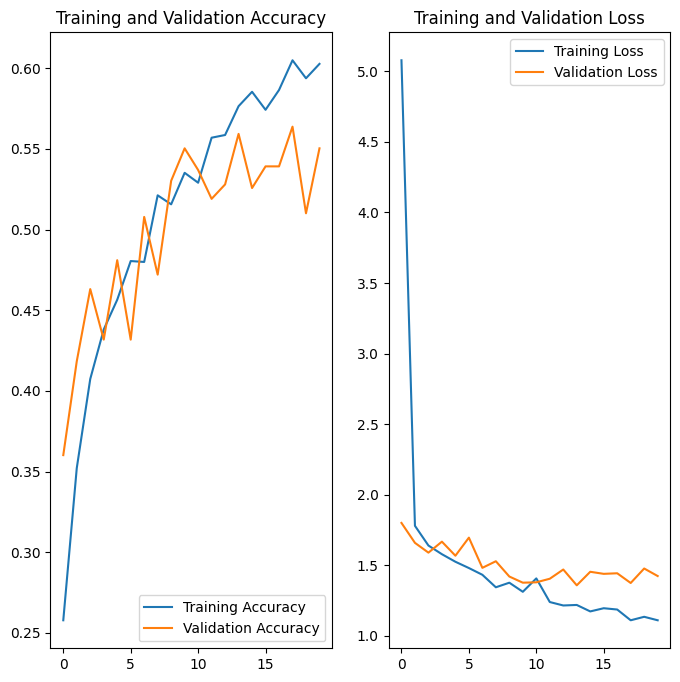

In [57]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Scond model finding:** After adding augmentation. The Second model looks to be underfit.

In [73]:
original_df = {}
file_paths = []
labels = []

base_dir = "D:\\pythonproject\\notebooks\\cnn\\CNN_assignment\\skin-cancer\\Train"

for root, dirs, files in os.walk(base_dir):
    rel_dir = os.path.relpath(root, base_dir)

    if rel_dir == ".":
        continue
    
    image_files = [os.path.join(root, file) for file in files if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]

    for image_file in image_files:
        original_df[image_file] = rel_dir


In [74]:
original_df_new = pd.DataFrame(list(original_df.items()),columns = ['Path','Label'])

In [75]:
original_df_new["Label"].value_counts()

Label
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64

**Classes are imbalance. Following classes have way less data then other classes**
1. squamous cell carcinoma
2. vascular lesion
3. actinic keratosis 
4. dermatofibroma
5. seborrheic keratosis

***seborrheic keratosis class has the least number of samples which is 77***

**Following classes dominate the data in terms proportionate number of samples:**
1. pigmented benign keratosis  - 462
2. melanoma - 438

#### Fixing Class imbalance

In [13]:
!pip install Augmentor


[notice] A new release of pip is available: 24.1.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [15]:
path_to_training_dataset="D:\\pythonproject\\notebooks\\cnn\\CNN_assignment\\skin-cancer\\Train\\"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to D:\pythonproject\notebooks\cnn\CNN_assignment\skin-cancer\Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CB05182730>: 100%|██████████| 500/500 [00:07<00:00, 63.56 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to D:\pythonproject\notebooks\cnn\CNN_assignment\skin-cancer\Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CB051A1910>: 100%|██████████| 500/500 [00:08<00:00, 59.37 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to D:\pythonproject\notebooks\cnn\CNN_assignment\skin-cancer\Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CB04FACF70>: 100%|██████████| 500/500 [00:07<00:00, 66.63 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to D:\pythonproject\notebooks\cnn\CNN_assignment\skin-cancer\Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1CB051C0820>: 100%|██████████| 500/500 [00:41<00:00, 12.00 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to D:\pythonproject\notebooks\cnn\CNN_assignment\skin-cancer\Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x1CB0519F5E0>: 100%|██████████| 500/500 [00:38<00:00, 13.10 Samples/s]                  


Initialised with 462 image(s) found.
Output directory set to D:\pythonproject\notebooks\cnn\CNN_assignment\skin-cancer\Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CB0514EE50>: 100%|██████████| 500/500 [00:08<00:00, 57.20 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to D:\pythonproject\notebooks\cnn\CNN_assignment\skin-cancer\Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1CB02AF4EB0>: 100%|██████████| 500/500 [00:15<00:00, 31.85 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to D:\pythonproject\notebooks\cnn\CNN_assignment\skin-cancer\Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CB02B6F280>: 100%|██████████| 500/500 [00:07<00:00, 63.88 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to D:\pythonproject\notebooks\cnn\CNN_assignment\skin-cancer\Train\vascular lesion\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1CB04FA9790>: 100%|██████████| 500/500 [00:08<00:00, 60.88 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [16]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [17]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_6ff61b23-548b-4123-b884-237eca636ed6.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_a779deee-a234-47b8-a234-563f801ea4ac.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_efe28cd3-11f6-4e79-b9aa-cea612a1ce36.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_2285e37c-af74-4211-9752-d0ef49eb25a2.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_23ac8fa8-3410-42a1-ba4a-a93cbd2e8e9f.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025825.jpg_0220b6c2-8d95-44a1-b8be-fe152acfc63b.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025825.jpg_28437c1d-2c11-4174-beb0-385bb7c927a6.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025825.jpg_71fc4e09-5553-4013-8d1e-e085fb514513.jpg',
 'Train\\actinic

In [18]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [19]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [20]:
dataframe_dict_new

{'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_6ff61b23-548b-4123-b884-237eca636ed6.jpg': 'actinic keratosis',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_a779deee-a234-47b8-a234-563f801ea4ac.jpg': 'actinic keratosis',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_efe28cd3-11f6-4e79-b9aa-cea612a1ce36.jpg': 'actinic keratosis',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_2285e37c-af74-4211-9752-d0ef49eb25a2.jpg': 'actinic keratosis',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_23ac8fa8-3410-42a1-ba4a-a93cbd2e8e9f.jpg': 'actinic keratosis',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025825.jpg_0220b6c2-8d95-44a1-b8be-fe152acfc63b.jpg': 'actinic keratosis',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025825.jpg_28437c1d-2c11-4174-beb0-385bb7c927a6.jpg': 'actinic kera

In [22]:
df_with_augmentation = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df_new, df_with_augmentation])

In [23]:
df_with_augmentation.shape,original_df_new.shape,new_df.shape

((4500, 2), (6739, 2), (11239, 2))

In [24]:
new_df.shape

(11239, 2)

In [25]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis           962
melanoma                             938
basal cell carcinoma                 876
nevus                                857
squamous cell carcinoma              681
vascular lesion                      639
actinic keratosis                    614
dermatofibroma                       595
seborrheic keratosis                 577
squamous cell carcinoma\output       500
seborrheic keratosis\output          500
nevus\output                         500
pigmented benign keratosis\output    500
actinic keratosis\output             500
melanoma\output                      500
dermatofibroma\output                500
basal cell carcinoma\output          500
vascular lesion\output               500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [26]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [27]:
data_dir_train="D:\\pythonproject\\notebooks\\cnn\\CNN_assignment\\skin-cancer\\Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [28]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create your model (make sure to include normalization)

In [31]:
model_3 = Sequential()
model_3.add(data_augmentation)
model_3.add(InputLayer(input_shape=train_x.shape[1:]))
model_3.add(Rescaling(scale=1/255))

model_3.add(Conv2D(64, (3, 3), padding='same'))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Conv2D(64, (3, 3), padding='same'))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.25))

model_3.add(Flatten())
model_3.add(Dense(256))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.25))
model_3.add(Dense(num_classes, activation='softmax'))

In [32]:

model_3.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [33]:
epochs = 30
history_3 = model_3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 859s 5s/step - loss: 3.3745 - accuracy: 0.2135 - val_loss: 1.8926 - val_accuracy: 0.2546
Epoch 2/30
169/169 [==============================] - 865s 5s/step - loss: 1.9834 - accuracy: 0.2658 - val_loss: 1.6599 - val_accuracy: 0.3742
Epoch 3/30
169/169 [==============================] - 773s 5s/step - loss: 1.6286 - accuracy: 0.3717 - val_loss: 1.6173 - val_accuracy: 0.3912
Epoch 4/30
169/169 [==============================] - 1074s 6s/step - loss: 1.4731 - accuracy: 0.4319 - val_loss: 1.4018 - val_accuracy: 0.4684
Epoch 5/30
169/169 [==============================] - 776s 5s/step - loss: 1.3738 - accuracy: 0.4751 - val_loss: 1.3555 - val_accuracy: 0.4803
Epoch 6/30
169/169 [==============================] - 717s 4s/step - loss: 1.3218 - accuracy: 0.4998 - val_loss: 1.3268 - val_accuracy: 0.4840
Epoch 7/30
169/169 [==============================] - 755s 4s/step - loss: 1.2305 - accuracy: 0.5334 - val_loss: 1.2323 - val_accuracy: 0.535

#### **Todo:**  Visualize the model results

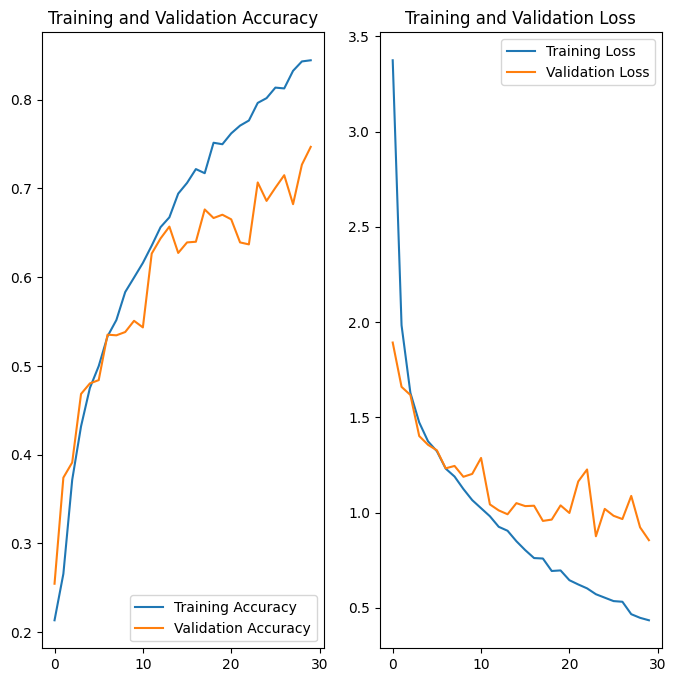

In [34]:
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']

loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


**Model 3 findings:**
The Model perform better then earlier two models.
